In [8]:
%matplotlib inline
import matplotlib.pyplot as plt

# number of hidden units for 2 layer 

In [12]:
import os,pickle,sys,numpy,nn,copy,scipy,scipy.io
import time

# --------------------------------------------
# Parameters
# --------------------------------------------
seed  = 3453
split = 2 # test split

mb    = 25     # size of the minibatch
hist  = 0.1    # fraction of the history to be remembered

# --------------------------------------------
# Load data
# --------------------------------------------
numpy.random.seed(seed)
if not os.path.exists('qm7.mat'): os.system('wget http://www.quantum-machine.org/data/qm7.mat')
dataset = scipy.io.loadmat('qm7.mat')

# --------------------------------------------
# Extract training data
# --------------------------------------------
P = dataset['P'][range(0,split)+range(split+1,5)].flatten()
X = dataset['X'][P]
T = dataset['T'][0,P]

# --------------------------------------------
# Create a neural network
# --------------------------------------------
I,O = nn.Input(X),nn.Output(T)
start = time.time()
for first_unit, second_unit in [(100,100), (200,200), (100,400), (400,100), (400,400)]:
    nnsgd = nn.Sequential([I,nn.Linear(I.nbout,first_unit),nn.Sigmoid(),
                           nn.Linear(first_unit,second_unit),nn.Sigmoid(),
                           nn.Linear(second_unit,O.nbinp),O])
    nnsgd.modules[-2].W *= 0
    nnavg = copy.deepcopy(nnsgd)

    # --------------------------------------------
    # Train the neural network
    # --------------------------------------------
    for i in range(1,10001):

        if i > 0:     lr = 0.001  # learning rate
        if i > 500:   lr = 0.0025
        if i > 2500:  lr = 0.005
        if i > 12500: lr = 0.01

        r = numpy.random.randint(0,len(X),[mb])
        Y = nnsgd.forward(X[r])
        nnsgd.backward(Y-T[r])
        nnsgd.update(lr)
        nnavg.average(nnsgd,(1/hist)/((1/hist)+i))
        nnavg.nbiter = i

        if i % 100 == 0: pickle.dump(nnavg,open('nn-%d-%d.pkl'%(first_unit,second_unit),'w'),pickle.HIGHEST_PROTOCOL)
    print "Time:", time.time()-start

Time: 359.0626719
Time: 746.441230059
Time: 1109.26516104
Time: 1546.99674892
Time: 2000.56317592


In [2]:
import os,pickle,sys,numpy,copy,scipy,scipy.io
import time
# --------------------------------------------
# Parameters
# --------------------------------------------
split = 2 # test split for cross-validation (between 0 and 5)

# --------------------------------------------
# Load data and models
# --------------------------------------------
if not os.path.exists('qm7.mat'): os.system('wget http://www.quantum-machine.org/data/qm7.mat')
dataset = scipy.io.loadmat('qm7.mat')
MAE_train = []
MAE_test = []
RMSE_train = []
RMSE_test = []

start = time.time()
for first_unit, second_unit in [(100,100), (200,200), (100,400), (400,100), (400,400)]:
    nn = pickle.load(open('nn-%d-%d.pkl'%(first_unit,second_unit),'r'))

    print('results after %d iterations'%nn.nbiter)

    Ptrain = dataset['P'][range(0,split)+range(split+1,5)].flatten()
    Ptest  = dataset['P'][split]

    for P,name in zip([Ptrain,Ptest],['training','test']):
        # --------------------------------------------
        # Extract test data
        # --------------------------------------------
        X = dataset['X'][P]
        T = dataset['T'][0,P]

        # --------------------------------------------
        # Test the neural network
        # --------------------------------------------
        print('\n%s set:'%name)
        Y = numpy.array([nn.forward(X) for _ in range(10)]).mean(axis=0)
        MAE = numpy.abs(Y-T).mean(axis=0)
        RMSE = numpy.square(Y-T).mean(axis=0)**.5
        print('MAE:  %5.2f kcal/mol'%MAE)
        print('RMSE: %5.2f kcal/mol'%RMSE)
        if name == 'training':
            MAE_train.append(MAE)
            RMSE_train.append(RMSE)
        else:
            MAE_test.append(MAE)
            RMSE_test.append(RMSE)
                
#         print('MAE:  %5.2f kcal/mol'%numpy.abs(Y-T).mean(axis=0))
#         print('RMSE: %5.2f kcal/mol'%numpy.square(Y-T).mean(axis=0)**.5)
print time.time()-start

results after 10000 iterations

training set:
MAE:   7.35 kcal/mol
RMSE: 10.76 kcal/mol

test set:
MAE:   7.26 kcal/mol
RMSE: 10.12 kcal/mol
results after 10000 iterations

training set:
MAE:   7.04 kcal/mol
RMSE: 10.23 kcal/mol

test set:
MAE:   7.09 kcal/mol
RMSE:  9.90 kcal/mol
results after 10000 iterations

training set:
MAE:   7.49 kcal/mol
RMSE: 10.78 kcal/mol

test set:
MAE:   7.36 kcal/mol
RMSE: 10.18 kcal/mol
results after 10000 iterations

training set:
MAE:   6.52 kcal/mol
RMSE:  9.66 kcal/mol

test set:
MAE:   6.63 kcal/mol
RMSE:  9.29 kcal/mol
results after 10000 iterations

training set:
MAE:   6.68 kcal/mol
RMSE:  9.68 kcal/mol

test set:
MAE:   6.73 kcal/mol
RMSE:  9.51 kcal/mol
131.112949848


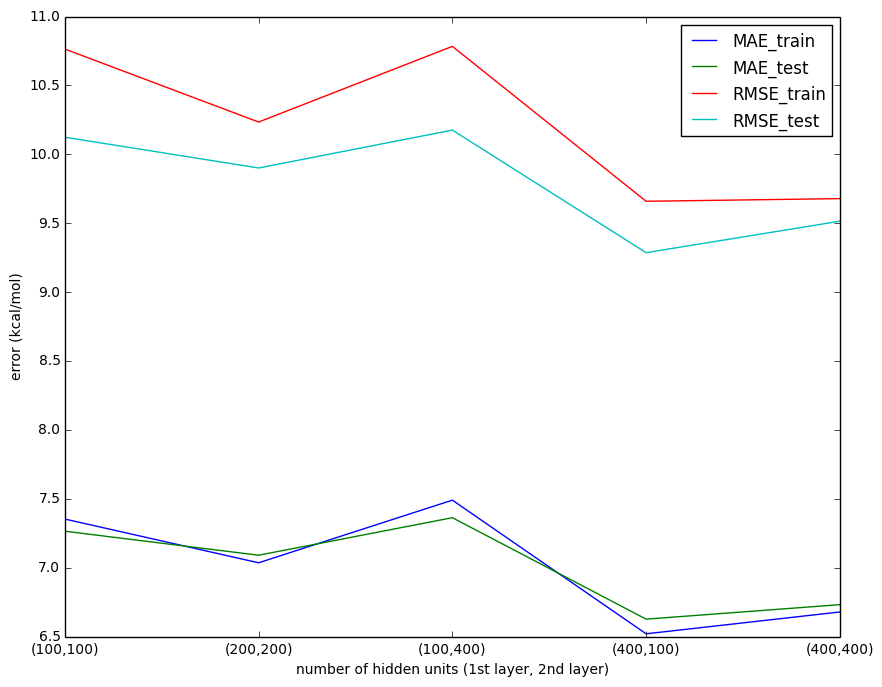

In [9]:
plt.figure(figsize=(10,8))
labels = ['(100,100)', '(200,200)', '(100,400)', '(400,100)', '(400,400)']
x = range(5)
plt.plot(x,MAE_train, label='MAE_train')
plt.plot(MAE_test, label='MAE_test')
plt.plot(RMSE_train, label='RMSE_train')
plt.plot(RMSE_test, label='RMSE_test')
plt.xticks(x, labels)
plt.legend()

plt.xlabel('number of hidden units (1st layer, 2nd layer)')
plt.ylabel('error (kcal/mol)')


# number of layers

In [18]:
import os,pickle,sys,numpy,nn,copy,scipy,scipy.io
import time

# --------------------------------------------
# Parameters
# --------------------------------------------
seed  = 3453
split = 2 # test split

mb    = 25     # size of the minibatch
hist  = 0.1    # fraction of the history to be remembered

# --------------------------------------------
# Load data
# --------------------------------------------
numpy.random.seed(seed)
if not os.path.exists('qm7.mat'): os.system('wget http://www.quantum-machine.org/data/qm7.mat')
dataset = scipy.io.loadmat('qm7.mat')

# --------------------------------------------
# Extract training data
# --------------------------------------------
P = dataset['P'][range(0,split)+range(split+1,5)].flatten()
X = dataset['X'][P]
T = dataset['T'][0,P]

# --------------------------------------------
# Create a neural network
# --------------------------------------------
I,O = nn.Input(X),nn.Output(T)
start = time.time()

module_structure = [[I,nn.Linear(I.nbout,400),nn.Sigmoid(),nn.Linear(400,O.nbinp),O], 
                    [I,nn.Linear(I.nbout,400),nn.Sigmoid(),nn.Linear(400,100),nn.Sigmoid(),nn.Linear(100,O.nbinp),O],
                    [I,nn.Linear(I.nbout,400),nn.Sigmoid(),nn.Linear(400,400),nn.Sigmoid(),nn.Linear(400,100),nn.Sigmoid(),
                     nn.Linear(100,O.nbinp),O]]

for n, module in enumerate(module_structure):
    nnsgd = nn.Sequential(module)
    nnsgd.modules[-2].W *= 0
    nnavg = copy.deepcopy(nnsgd)

    # --------------------------------------------
    # Train the neural network
    # --------------------------------------------
    for i in range(1,10001):

        if i > 0:     lr = 0.001  # learning rate
        if i > 500:   lr = 0.0025
        if i > 2500:  lr = 0.005
        if i > 12500: lr = 0.01

        r = numpy.random.randint(0,len(X),[mb])
        Y = nnsgd.forward(X[r])
        nnsgd.backward(Y-T[r])
        nnsgd.update(lr)
        nnavg.average(nnsgd,(1/hist)/((1/hist)+i))
        nnavg.nbiter = i

        if i % 100 == 0: pickle.dump(nnavg,open('nn-%d-layer.pkl'%(n+1),'w'),pickle.HIGHEST_PROTOCOL)
    print "Time:", time.time()-start

Time: 430.209930182
Time: 866.078837156
Time: 1319.08163309


In [21]:
import os,pickle,sys,numpy,copy,scipy,scipy.io
import time
# --------------------------------------------
# Parameters
# --------------------------------------------
split = 2 # test split for cross-validation (between 0 and 5)

# --------------------------------------------
# Load data and models
# --------------------------------------------
if not os.path.exists('qm7.mat'): os.system('wget http://www.quantum-machine.org/data/qm7.mat')
dataset = scipy.io.loadmat('qm7.mat')
MAE_train = []
MAE_test = []
RMSE_train = []
RMSE_test = []

start = time.time()
for i in range(1,4):
    nn = pickle.load(open('nn-%d-layer.pkl'%(i),'r'))

    print('results after %d iterations'%nn.nbiter)

    Ptrain = dataset['P'][range(0,split)+range(split+1,5)].flatten()
    Ptest  = dataset['P'][split]

    for P,name in zip([Ptrain,Ptest],['training','test']):
        # --------------------------------------------
        # Extract test data
        # --------------------------------------------
        X = dataset['X'][P]
        T = dataset['T'][0,P]

        # --------------------------------------------
        # Test the neural network
        # --------------------------------------------
        print('\n%s set:'%name)
        Y = numpy.array([nn.forward(X) for _ in range(10)]).mean(axis=0)
        MAE = numpy.abs(Y-T).mean(axis=0)
        RMSE = numpy.square(Y-T).mean(axis=0)**.5
        print('MAE:  %5.2f kcal/mol'%MAE)
        print('RMSE: %5.2f kcal/mol'%RMSE)
        if name == 'training':
            MAE_train.append(MAE)
            RMSE_train.append(RMSE)
        else:
            MAE_test.append(MAE)
            RMSE_test.append(RMSE)
                
print time.time()-start

results after 10000 iterations

training set:
MAE:   7.07 kcal/mol
RMSE: 10.12 kcal/mol

test set:
MAE:   7.16 kcal/mol
RMSE:  9.79 kcal/mol
results after 10000 iterations

training set:
MAE:   6.39 kcal/mol
RMSE:  9.56 kcal/mol

test set:
MAE:   6.47 kcal/mol
RMSE:  8.95 kcal/mol
results after 10000 iterations

training set:
MAE:   6.35 kcal/mol
RMSE:  9.52 kcal/mol

test set:
MAE:   6.70 kcal/mol
RMSE:  9.20 kcal/mol
83.6282289028


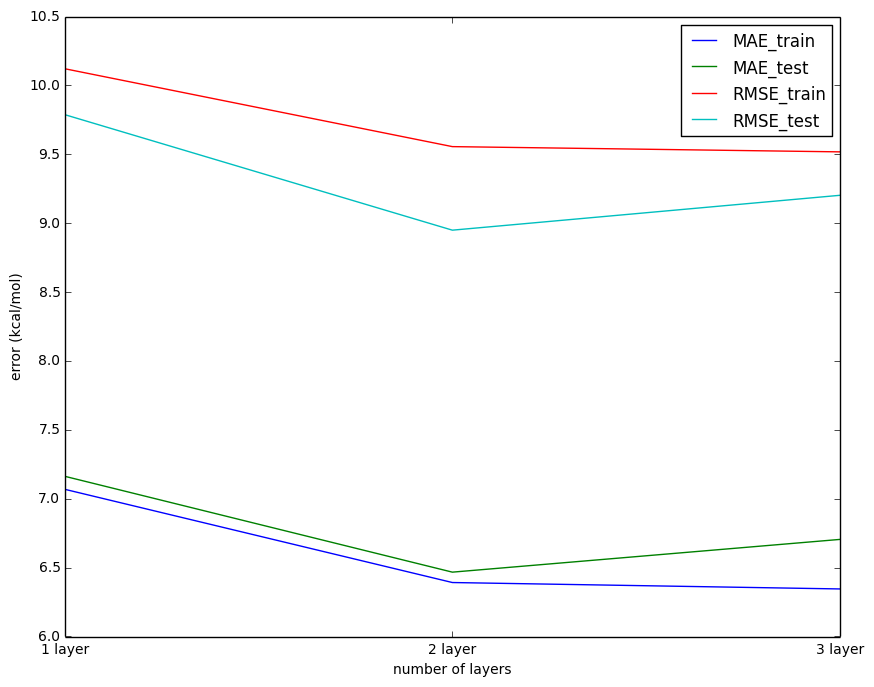

In [22]:
plt.figure(figsize=(10,8))
labels = ['1 layer', '2 layer', '3 layer']
x = range(3)
plt.plot(x,MAE_train, label='MAE_train')
plt.plot(MAE_test, label='MAE_test')
plt.plot(RMSE_train, label='RMSE_train')
plt.plot(RMSE_test, label='RMSE_test')
plt.xticks(x, labels)
plt.legend()

plt.xlabel('number of layers')
plt.ylabel('error (kcal/mol)')

# minibatch size

In [25]:
import os,pickle,sys,numpy,nn,copy,scipy,scipy.io
import time

# --------------------------------------------
# Parameters
# --------------------------------------------
seed  = 3453
split = 2 # test split

# mb    = 25     # size of the minibatch
hist  = 0.1    # fraction of the history to be remembered

# --------------------------------------------
# Load data
# --------------------------------------------
numpy.random.seed(seed)
if not os.path.exists('qm7.mat'): os.system('wget http://www.quantum-machine.org/data/qm7.mat')
dataset = scipy.io.loadmat('qm7.mat')

# --------------------------------------------
# Extract training data
# --------------------------------------------
P = dataset['P'][range(0,split)+range(split+1,5)].flatten()
X = dataset['X'][P]
T = dataset['T'][0,P]

# --------------------------------------------
# Create a neural network
# --------------------------------------------
I,O = nn.Input(X),nn.Output(T)
start = time.time()


for mb in [1,5,25,100,500]:
    nnsgd = nn.Sequential([I,nn.Linear(I.nbout,400),nn.Sigmoid(),
                           nn.Linear(400,100),nn.Sigmoid(),
                           nn.Linear(100,O.nbinp),O])
    nnsgd.modules[-2].W *= 0
    nnavg = copy.deepcopy(nnsgd)

    # --------------------------------------------
    # Train the neural network
    # --------------------------------------------
    for i in range(1,10001):

        if i > 0:     lr = 0.001  # learning rate
        if i > 500:   lr = 0.0025
        if i > 2500:  lr = 0.005
        if i > 12500: lr = 0.01

        r = numpy.random.randint(0,len(X),[mb])
        Y = nnsgd.forward(X[r])
        nnsgd.backward(Y-T[r])
        nnsgd.update(lr)
        nnavg.average(nnsgd,(1/hist)/((1/hist)+i))
        nnavg.nbiter = i

        if i % 100 == 0: pickle.dump(nnavg,open('nn-%d-minibatch.pkl'%(mb),'w'),pickle.HIGHEST_PROTOCOL)
    print "Time:", time.time()-start

Time: 330.259541988
Time: 681.687541008
Time: 1108.95415616
Time: 1853.82096601


nn.py:94: RuntimeWarning: overflow encountered in multiply
  DX = self.tr * numpy.dot(DY,self.W.T)
nn.py:115: RuntimeWarning: invalid value encountered in multiply
  return DY * (1-self.Y**2)


Time: 4249.41601801


In [12]:
import os,pickle,sys,numpy,copy,scipy,scipy.io
import time
# --------------------------------------------
# Parameters
# --------------------------------------------
split = 2 # test split for cross-validation (between 0 and 5)

# --------------------------------------------
# Load data and models
# --------------------------------------------
if not os.path.exists('qm7.mat'): os.system('wget http://www.quantum-machine.org/data/qm7.mat')
dataset = scipy.io.loadmat('qm7.mat')
MAE_train = []
MAE_test = []
RMSE_train = []
RMSE_test = []

start = time.time()
for mb in [1,5,25,100,500]:
    nn = pickle.load(open('nn-%d-minibatch.pkl'%(mb),'r'))

    print('results after %d iterations'%nn.nbiter)

    Ptrain = dataset['P'][range(0,split)+range(split+1,5)].flatten()
    Ptest  = dataset['P'][split]

    for P,name in zip([Ptrain,Ptest],['training','test']):
        # --------------------------------------------
        # Extract test data
        # --------------------------------------------
        X = dataset['X'][P]
        T = dataset['T'][0,P]

        # --------------------------------------------
        # Test the neural network
        # --------------------------------------------
        print('\n%s set:'%name)
        Y = numpy.array([nn.forward(X) for _ in range(10)]).mean(axis=0)
        MAE = numpy.abs(Y-T).mean(axis=0)
        RMSE = numpy.square(Y-T).mean(axis=0)**.5
        print('MAE:  %5.2f kcal/mol'%MAE)
        print('RMSE: %5.2f kcal/mol'%RMSE)
        if name == 'training':
            MAE_train.append(MAE)
            RMSE_train.append(RMSE)
        else:
            MAE_test.append(MAE)
            RMSE_test.append(RMSE)
                
print time.time()-start

results after 10000 iterations

training set:
MAE:  16.41 kcal/mol
RMSE: 24.24 kcal/mol

test set:
MAE:  15.83 kcal/mol
RMSE: 22.77 kcal/mol
results after 10000 iterations

training set:
MAE:   9.81 kcal/mol
RMSE: 14.58 kcal/mol

test set:
MAE:   9.75 kcal/mol
RMSE: 13.77 kcal/mol
results after 10000 iterations

training set:
MAE:   6.59 kcal/mol
RMSE:  9.78 kcal/mol

test set:
MAE:   6.65 kcal/mol
RMSE:  9.31 kcal/mol
results after 10000 iterations

training set:
MAE:   4.89 kcal/mol
RMSE:  7.46 kcal/mol

test set:
MAE:   5.33 kcal/mol
RMSE:  7.45 kcal/mol
results after 10000 iterations

training set:
MAE:    nan kcal/mol
RMSE:   nan kcal/mol

test set:
MAE:    nan kcal/mol
RMSE:   nan kcal/mol
130.840695858


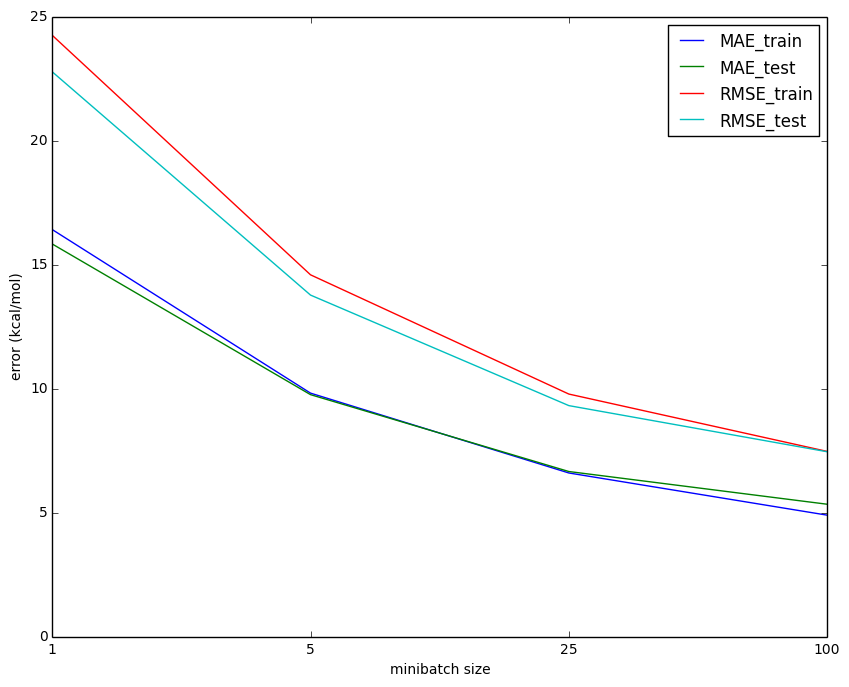

In [20]:
plt.figure(figsize=(10,8))
labels = [1,5,25,100]
x = range(4)
plt.plot(x,MAE_train[:-1], label='MAE_train')
plt.plot(MAE_test[:-1], label='MAE_test')
plt.plot(RMSE_train[:-1], label='RMSE_train')
plt.plot(RMSE_test[:-1], label='RMSE_test')
plt.xticks(x, labels)
plt.legend()

plt.xlabel('minibatch size')
plt.ylabel('error (kcal/mol)')

In [16]:
nn.modules[5].__dict__

{'A': array([ nan,  nan,  nan,  nan,  nan,  nan,  nan,  nan,  nan,  nan,  nan,
         nan,  nan,  nan,  nan,  nan,  nan,  nan,  nan,  nan,  nan,  nan,
         nan,  nan,  nan,  nan,  nan,  nan,  nan,  nan,  nan,  nan,  nan,
         nan,  nan,  nan,  nan,  nan,  nan,  nan,  nan,  nan,  nan,  nan,
         nan,  nan,  nan,  nan,  nan,  nan,  nan,  nan,  nan,  nan,  nan,
         nan,  nan,  nan,  nan,  nan,  nan,  nan,  nan,  nan,  nan,  nan,
         nan,  nan,  nan,  nan,  nan,  nan,  nan,  nan,  nan,  nan,  nan,
         nan,  nan,  nan,  nan,  nan,  nan,  nan,  nan,  nan,  nan,  nan,
         nan,  nan,  nan,  nan,  nan,  nan,  nan,  nan,  nan,  nan,  nan,
         nan], dtype=float32),
 'B': array([ nan], dtype=float32),
 'W': array([[ nan],
        [ nan],
        [ nan],
        [ nan],
        [ nan],
        [ nan],
        [ nan],
        [ nan],
        [ nan],
        [ nan],
        [ nan],
        [ nan],
        [ nan],
        [ nan],
        [ nan],
        [ nan],
 